# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [18]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d_sim import *
from MaaSSim.d2d_demand import *
from MaaSSim.d2d_supply import *
from MaaSSim.shared import prep_shared_rides
from MaaSSim.decisions import dummy_False

In [20]:
import pandas as pd
import zipfile
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

In [21]:
# Load config
params = get_config('../../data/config/ams.json')  # load configuration

In [22]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 1

# Main experimental settings
params.nP = 2000 # travellers
params.nV = 20 # drivers
params.nD = 3 # days
params.simTime = 8 # hours

In [23]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 10 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 10 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

params.evol.travellers.inform.prob_start = 1
params.evol.travellers.inform.beta = 0.2

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.63 #euro/km
params.platforms.min_fare = 6 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Properties alternative modes
params.alt_modes.pt.base_fare = 0.99 # euro
params.alt_modes.pt.km_fare = 0.174 # euro/km
params.alt_modes.pt.access_time = 10 * 60  #s, includes egress (not waiting)
params.alt_modes.pt.wait_time = 7.5 * 60 #s
params.alt_modes.car.km_cost = 0.5 # euro/km
params.alt_modes.car.park_cost = 5 # euro
params.alt_modes.car.access_time = 10 * 60 # s
params.speeds.bike = 4 # m/s
params.speeds.pt = 0.5 * params.speeds.ride # considering stops

# Mode choice parameters
params.mode_choice.ASC_car = 0 # util, rel to bike
params.mode_choice.ASC_rs = 0
params.mode_choice.ASC_pt = 0
params.mode_choice.beta_access = -0.0475 / 60 # util/s
params.mode_choice.beta_cost = -0.1515 # util/euro
params.mode_choice.beta_time_bike = -0.0693 / 60 #util/s
params.mode_choice.beta_time_moto = -0.0106 / 60
params.mode_choice.beta_wait_rs = -0.0156 / 60
params.mode_choice.beta_wait_pt = -0.0398 / 60

# Demand settings
params.demand_structure.origins_dispertion = -0.0003
params.demand_structure.destinations_dispertion = -0.0003
params.dist_threshold_min = 2000 # min dist
params.dist_threshold = 100000 # max dist

# Start time
params.t0 = pd.Timestamp.now()

In [24]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
inData.passengers['informed'] = np.random.rand(params.nP) < params.evol.travellers.inform.prob_start
inData.passengers['expected_wait'] = 0
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [26]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    kpi_pax = d2d_kpi_pax,
                    f_driver_out = D2D_driver_out,
                    f_trav_out = d2d_no_request,
                    f_trav_mode = dummy_False,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf_driver = wom_driver(inData, params = params)
    inData.vehicles.informed = res_inf_driver
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos
    res_inf_trav = wom_trav(inData, params = params)
    inData.passengers.informed = res_inf_trav

evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

25-03-21 16:47:39-WARNING-Setting up 8h simulation at 2021-03-25 12:42:57 for 20 vehicles and 2000 passengers in Amsterdam, Netherlands
25-03-21 16:48:05-WARNING-day 0: simulation time 21.5 s
25-03-21 16:48:07-WARNING-assertion tests for simulation results - passed
25-03-21 16:48:33-WARNING-day 1: simulation time 21.5 s
25-03-21 16:48:35-WARNING-assertion tests for simulation results - passed
25-03-21 16:49:10-WARNING-day 2: simulation time 30.5 s
25-03-21 16:49:13-WARNING-assertion tests for simulation results - passed


In [27]:
with zipfile.ZipFile('evol.zip', 'w') as csv_zip:
    csv_zip.writestr("evol_agg_supply.csv", evol_agg.supply.to_csv())
    csv_zip.writestr("evol_agg_demand.csv", evol_agg.demand.to_csv())

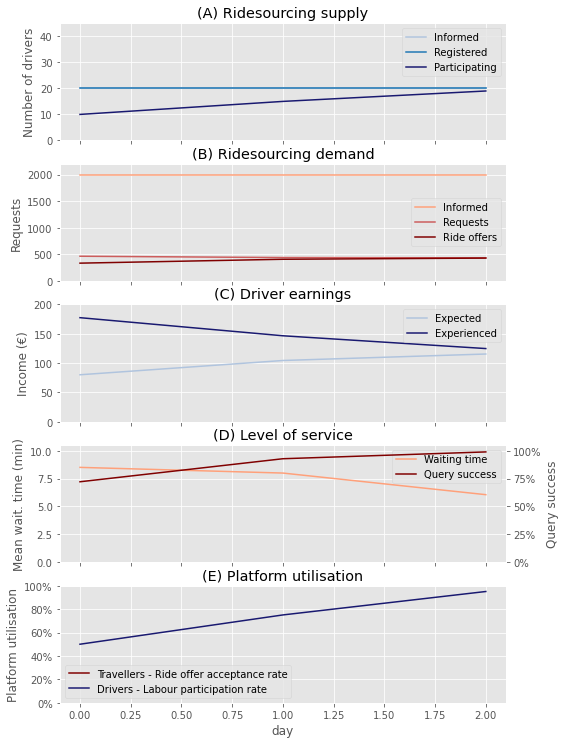

In [28]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (8,12.5), sharex = True)
evol_agg.supply[['inform','regist','particip']].plot(ax = axes[0], color=['lightsteelblue','tab:blue','midnightblue'])
axes[0].set_title('(A) Ridesourcing supply')
axes[0].legend(['Informed','Registered','Participating'])
axes[0].set_ylim([0,params.nV + 25])
axes[0].set_ylabel('Number of drivers')
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[2], color=['lightsteelblue','midnightblue'])
axes[2].set_title('(C) Driver earnings')
axes[2].legend(['Expected','Experienced'])
axes[2].set_ylim([0,math.ceil(max(evol_agg.supply.mean_perc_inc.max(),evol_agg.supply.mean_exp_inc.max())/50)*50])
axes[2].set_ylabel('Income (\u20ac)')

evol_agg.demand[['inform','requests','gets_offer']].plot(ax = axes[1], color=['lightsalmon','indianred','maroon'])
axes[1].set_title('(B) Ridesourcing demand')
axes[1].legend(['Informed','Requests','Ride offers'])
axes[1].set_ylim([0,params.nP * 1.1])
axes[1].set_ylabel('Requests')

ax_sec = axes[3].twinx()
evol_agg.demand['proport_match'] = evol_agg.demand.gets_offer / evol_agg.demand.requests * 100
evol_agg.demand['mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Waiting time', color ='lightsalmon')
evol_agg.demand['proport_match'].plot(ax = ax_sec, color = 'maroon', label='Query success')
lines_1, labels_1 = axes[3].get_legend_handles_labels()
lines_2, labels_2 = ax_sec.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axes[3].legend(lines, labels, loc=0)
axes[3].set_title('(D) Level of service')
axes[3].set_ylabel('Mean wait. time (min)')
ax_sec.set_ylabel('Query success')
ax_sec.yaxis.set_major_formatter(mtick.PercentFormatter())
axes[3].set_ylim([0,math.ceil(evol_agg.demand[['mean_wait']].apply(lambda x: 1/60 * x).max()/2)*2+0.5])
ax_sec.set_ylim([0,100+5])
ax_sec.grid(None)

proport_rs = evol_agg.demand.accepts_offer / evol_agg.demand.gets_offer * 100 
proport_rs.plot(ax = axes[4], label = 'Travellers - Ride offer acceptance rate', color='maroon')
axes[4].set_title('(E) Platform utilisation')
axes[4].set_ylim([0,100])
axes[4].set_ylabel('Platform utilisation')

axes[4].yaxis.set_major_formatter(mtick.PercentFormatter())

proport_work = evol_agg.supply.particip / evol_agg.supply.regist * 100
proport_work.plot(ax = axes[4], label = 'Drivers - Labour participation rate', color ='midnightblue')
lines, labels = axes[4].get_legend_handles_labels()
axes[4].legend(labels)

plt.savefig('d2d-evo.png')

In [29]:
evol_agg.supply

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,20,20,10,80.000000,177.464360
1,20,20,15,104.366090,146.559293
2,20,20,19,115.420549,124.739736


In [30]:
evol_agg.demand

,inform,requests,gets_offer,accepts_offer,mean_wait,proport_match
day,,,,,,
0,2000,466,336,336,510.014881,72.103004
1,2000,441,409,409,479.437653,92.743764
2,2000,436,431,431,363.192575,98.853211


In [31]:
inData.passengers

,pos,event,platforms,informed,expected_wait
pax,,,,,
0,7934128437,NaN,[0],True,0
1,46422430,NaN,[0],True,0
2,415961034,NaN,[0],True,0
3,313226701,NaN,[0],True,0
4,46341500,NaN,[0],True,0
...,...,...,...,...,...
1995,4836569840,NaN,[0],True,0
1996,46404530,NaN,[0],True,0
1997,2103982579,NaN,[0],True,0


In [32]:
d2d.travs[2]

,orig,dest,t_req,tt_min,dist,informed,requests,gets_offer,accepts_offer,xp_wait,xp_ivt,xp_ops,xp_tt_total,exp_tt_wait_prev
pax,,,,,,,,,,,,,,
1,7934128437,46343767,2021-03-25 12:42:57,0 days 00:11:24,6844,True,True,True,True,139.0,684.0,55.0,878.0,0
2,46422430,46286216,2021-03-25 12:43:05,0 days 00:06:43,4037,True,False,False,False,NaN,NaN,NaN,NaN,0
3,415961034,46429658,2021-03-25 12:43:21,0 days 00:04:45,2859,True,True,True,True,222.0,285.0,55.0,562.0,0
4,313226701,46355973,2021-03-25 12:43:33,0 days 00:11:16,6766,True,False,False,False,NaN,NaN,NaN,NaN,0
5,46341500,46405265,2021-03-25 12:43:36,0 days 00:08:57,5372,True,True,True,True,126.0,537.0,55.0,718.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,4836569840,46271461,2021-03-25 20:41:21,0 days 00:16:15,9751,True,False,False,False,NaN,NaN,NaN,NaN,0
1997,46404530,46440527,2021-03-25 20:41:36,0 days 00:22:15,13358,True,False,False,False,NaN,NaN,NaN,NaN,0
1998,2103982579,46290263,2021-03-25 20:41:42,0 days 00:12:45,7658,True,False,False,False,NaN,NaN,NaN,NaN,0


In [33]:
sim.res[2].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DEST,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,LOSES_PATIENCE,MEETS_DRIVER_AT_PICKUP,PREFERS_OTHER_SERVICE,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,NO_REQUEST,OTHER_MODE,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,,,
0,15.0,0.0,684.0,20.0,30.0,0.0,139.0,0.0,0.0,0.0,10.0,False,False,0,0,0,684.0,139.0,55.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
2,15.0,0.0,285.0,20.0,30.0,0.0,222.0,0.0,0.0,24.0,10.0,False,False,0,0,0,285.0,222.0,55.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
4,15.0,0.0,537.0,20.0,30.0,0.0,126.0,0.0,0.0,39.0,10.0,False,False,0,0,0,537.0,126.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0


In [34]:
sim.passengers

,pos,event,platforms,informed,expected_wait
pax,,,,,
0,46343767,travellerEvent.ARRIVES_AT_DEST,[0],True,0
1,46422430,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0
2,46429658,travellerEvent.ARRIVES_AT_DEST,[0],True,0
3,313226701,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0
4,46405265,travellerEvent.ARRIVES_AT_DEST,[0],True,0
...,...,...,...,...,...
1995,4836569840,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0
1996,46404530,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0
1997,2103982579,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0


In [35]:
sim.runs[2].trips

,pax,pos,t,event,veh_id
0,0,7934128437,0,STARTS_DAY,NaN
1,0,7934128437,0,REQUESTS_RIDE,NaN
2,0,7934128437,0,RECEIVES_OFFER,NaN
3,0,7934128437,15,ACCEPTS_OFFER,NaN
4,0,7934128437,35,ARRIVES_AT_PICKUP,8.0
...,...,...,...,...,...
1,1997,2103982579,0,PREFERS_OTHER_SERVICE,NaN
0,1998,46255113,0,STARTS_DAY,NaN
1,1998,46255113,0,PREFERS_OTHER_SERVICE,NaN
0,1999,46379144,0,STARTS_DAY,NaN
